# Natural and artificial perturbations

In [1]:
import functools

import numpy as np
import matplotlib.pyplot as plt
plt.ion()

from astropy import units as u
from astropy.time import Time
from astropy.coordinates import solar_system_ephemeris

from poliastro.twobody.propagation import propagate, cowell
from poliastro.ephem import build_ephem_interpolant
from poliastro.core.elements import rv2coe

from poliastro.core.util import norm
from poliastro.util import time_range
from poliastro.core.perturbations import (
    atmospheric_drag, third_body, J2_perturbation
)
from poliastro.bodies import Earth, Moon
from poliastro.twobody import Orbit
from poliastro.plotting import OrbitPlotter2D, OrbitPlotter3D

### Atmospheric drag ###
The poliastro package now has several commonly used natural perturbations. One of them is atmospheric drag! See how one can monitor decay of the near-Earth orbit over time using our new module poliastro.twobody.perturbations!

In [2]:
R = Earth.R.to(u.km).value
k = Earth.k.to(u.km**3 / u.s**2).value

orbit = Orbit.circular(Earth, 250 * u.km, epoch=Time(0.0, format='jd', scale='tdb'))

# parameters of a body
C_D = 2.2  # dimentionless (any value would do)
A = ((np.pi / 4.0) * (u.m**2)).to(u.km**2).value  # km^2
m = 100  # kg
B = C_D * A / m

# parameters of the atmosphere
rho0 = Earth.rho0.to(u.kg / u.km**3).value  # kg/km^3
H0 = Earth.H0.to(u.km).value
tof = (100000 * u.s).to(u.day).value
tr = time_range(0.0, periods=2000, end=tof, format='jd', scale='tdb')
cowell_with_ad = functools.partial(cowell, ad=atmospheric_drag,
                                   R=R, C_D=C_D, A=A, m=m, H0=H0, rho0=rho0)

rr = propagate(
    orbit, (tr - orbit.epoch).to(u.s), method=cowell_with_ad
)

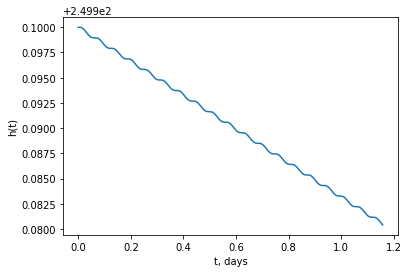

In [3]:
plt.ylabel('h(t)')
plt.xlabel('t, days')
plt.plot(tr.value, rr.data.norm() - Earth.R);

### Evolution of RAAN due to the J2 perturbation ###
We can also see how the J2 perturbation changes RAAN over time!

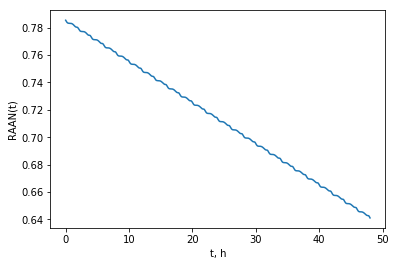

In [4]:
r0 = np.array([-2384.46, 5729.01, 3050.46]) * u.km
v0 = np.array([-7.36138, -2.98997, 1.64354]) * u.km / u.s

orbit = Orbit.from_vectors(Earth, r0, v0)

tof = 48.0 * u.h

# This will be easier with propagate
# when this is solved:
# https://github.com/poliastro/poliastro/issues/257
rr, vv = cowell(
    Earth.k,
    orbit.r,
    orbit.v,
    np.linspace(0, tof, 2000),
    ad=J2_perturbation,
    J2=Earth.J2.value,
    R=Earth.R.to(u.km).value
)

k = Earth.k.to(u.km**3 / u.s**2).value
rr = rr.to(u.km).value
vv = vv.to(u.km / u.s).value

raans = [rv2coe(k, r, v)[3] for r, v in zip(rr, vv)]
plt.ylabel('RAAN(t)')
plt.xlabel('t, h')
plt.plot(np.linspace(0, tof, 2000), raans);

### 3rd body ###
Apart from time-independent perturbations such as atmospheric drag, J2/J3, we have time-dependend perturbations. Lets's see how Moon changes the orbit of GEO satellite over time!

In [5]:
# database keeping positions of bodies in Solar system over time
solar_system_ephemeris.set('de432s')

j_date = 2454283.0 * u.day  # setting the exact event date is important

tof = (60 * u.day).to(u.s).value

# create interpolant of 3rd body coordinates (calling in on every iteration will be just too slow)
body_r = build_ephem_interpolant(Moon, 28 * u.day, (j_date, j_date + 60 * u.day), rtol=1e-2)

epoch = Time(j_date, format='jd', scale='tdb')
initial = Orbit.from_classical(Earth, 42164.0 * u.km, 0.0001 * u.one, 1 * u.deg, 
                               0.0 * u.deg, 0.0 * u.deg, 0.0 * u.rad, epoch=epoch)

# multiply Moon gravity by 400 so that effect is visible :)
cowell_with_3rdbody = functools.partial(cowell, rtol=1e-6, ad=third_body,
                                        k_third=400 * Moon.k.to(u.km**3 / u.s**2).value, 
                                        third_body=body_r)

tr = time_range(j_date.value, periods=1000, end=j_date.value + 60, format='jd', scale='tdb')

rr = propagate(
    initial, (tr - initial.epoch).to(u.s), method=cowell_with_3rdbody
)

In [6]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr, label='orbit influenced by Moon')

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'solid', 'width': 5},
            …

### Thrusts ###
Apart from natural perturbations, there are artificial thrusts aimed at intentional change of orbit parameters. One of such changes is simultaineous change of eccenricy and inclination.

In [7]:
from poliastro.twobody.thrust import change_inc_ecc

ecc_0, ecc_f = 0.4, 0.0
a = 42164  # km
inc_0 = 0.0  # rad, baseline
inc_f = (20.0 * u.deg).to(u.rad).value  # rad
argp = 0.0  # rad, the method is efficient for 0 and 180
f = 2.4e-6  # km / s2

k = Earth.k.to(u.km**3 / u.s**2).value
s0 = Orbit.from_classical(
    Earth,
    a * u.km, ecc_0 * u.one, inc_0 * u.deg,
    0 * u.deg, argp * u.deg, 0 * u.deg,
    epoch=Time(0, format='jd', scale='tdb')
)
    
a_d, _, _, t_f = change_inc_ecc(s0, ecc_f, inc_f, f)

cowell_with_ad = functools.partial(cowell, rtol=1e-6, ad=a_d)

tr = time_range(0.0, periods=1000, end=(t_f * u.s).to(u.day).value, format='jd', scale='tdb')

rr2 = propagate(
    s0, (tr - s0.epoch).to(u.s), method=cowell_with_ad
)

In [8]:
frame = OrbitPlotter3D()

frame.set_attractor(Earth)
frame.plot_trajectory(rr2, label='orbit with artificial thrust')

FigureWidget({
    'data': [{'line': {'color': 'rgb(31, 119, 180)', 'dash': 'solid', 'width': 5},
            …